## Random forest

In [1]:
from Functions.Common_functions import load_data
import pandas as pd

### Load data

In [2]:
PATH = ""

columns=['Relative Compactness','Surface Area', 'Wall Area','Roof Area', 'Overall Height', 'Orientation', 'Glazing Area',
'Glazing Area Distribution', 'Heating Load', 'Cooling Load']
eng_df = load_data("","ENB2012_data.csv", columns)

### Complete pipeline to transform data

In [3]:
from sklearn.pipeline import Pipeline
from Functions.Data_analysis import *
from Functions.Logistic_regression import LineDropper, FloatData

import numpy as np


columns_X = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Orientation', 
             'Glazing Area', 'Glazing Area Distribution']
columns_y = ['Label', 'Efficiency']

pipeline = Pipeline([
    ('drop_lines', LineDropper(line_dropped=0)),
    ('float', FloatData()),
    ('number', SumEfficiency(["Heating Load", "Cooling Load"])),
    ('label', LabelEfficiency("Label")),
    ('drop_columns', FeatureDropper(["Heating Load", "Cooling Load"])),
])

dataset = pipeline.fit_transform(eng_df)
dataset_df = pd.DataFrame(data=dataset, columns= np.concatenate((columns_X, columns_y)))
dataset_df.head()



Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.98         514.5      294.0     110.25             7.0   
5                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Label Efficiency  
1          2.0           0.0                        0.0  36.88          C  
2          3.0           0.0                        0.0  36.88          C  
3          4.0           0.0                        0.0  36.88          C  
4          5.0           0.0                        0.0  36.88          C  
5          2.0           0.0                        0.0  49.12          D

## Duplication

In [5]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled_b = ros.fit_resample(X= dataset_df[dataset_df.columns[0:8]], y=dataset_df["Efficiency"])

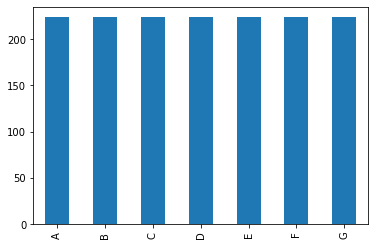

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
y_resampled_b.value_counts().sort_index().plot.bar()

### Create test set

In [9]:
from sklearn.model_selection import train_test_split, cross_val_predict
X_train, X_test, y_train_b, y_test_b = train_test_split(X_resampled, y_resampled_b, 
                                             test_size=0.20, random_state=42)

### Random forest algorithm
On garde la 3ème technique qui est la meilleure

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(max_depth=None, oob_score=True, max_features='sqrt', n_jobs=-1)
clf_3 = GridSearchCV(estimator=random_forest, 
                     param_grid={'criterion': ('gini', 'entropy'),
                               'class_weight': ('balanced', 'balanced_subsample'),
                               'ccp_alpha': np.linspace(start=0, stop=0.02, num=50)})

clf_3.fit(X_train, y_train_b)

GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt', n_jobs=-1,
                                              oob_score=True),
             param_grid={'ccp_alpha': array([0.        , 0.00040816, 0.00081633, 0.00122449, 0.00163265,
       0.00204082, 0.00244898, 0.00285714, 0.00326531, 0.00367347,
       0.00408163, 0.0044898 , 0.00489796, 0.00530612, 0.00571429,
       0.00612245, 0.00653061, 0.00693878, 0.00734694, 0.0077551 ,
       0.00816327, 0.0085...
       0.01020408, 0.01061224, 0.01102041, 0.01142857, 0.01183673,
       0.0122449 , 0.01265306, 0.01306122, 0.01346939, 0.01387755,
       0.01428571, 0.01469388, 0.01510204, 0.0155102 , 0.01591837,
       0.01632653, 0.01673469, 0.01714286, 0.01755102, 0.01795918,
       0.01836735, 0.01877551, 0.01918367, 0.01959184, 0.02      ]),
                         'class_weight': ('balanced', 'balanced_subsample'),
                         'criterion': ('gini', 'entropy')})

In [11]:
clf_3.best_params_

{'ccp_alpha': 0.00040816326530612246,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini'}

In [12]:
clf_3.best_estimator_.oob_score_

0.9776714513556619

In [13]:
clf_3.score(X=X_test, y=y_test_b)

0.9777070063694268

Lors du resampling, nous n'avons que fait de la duplication de data pour avoir le même nombre de valeurs par classes. 
Nous pouvons observer que cette duplication fonctionne très bien. 

## SMOTE
Cependant, il existe un autre algorithme (SMOTE) qui permet de créer de nouveaux échantillons à côté des données dans
un algorithme de KNN.

In [22]:
from imblearn.over_sampling import ADASYN,SMOTE
X_resampled_SMOTE, y_resampled_SMOTE = SMOTE().fit_resample(X= dataset_df[dataset_df.columns[0:8]], y=dataset_df["Efficiency"])

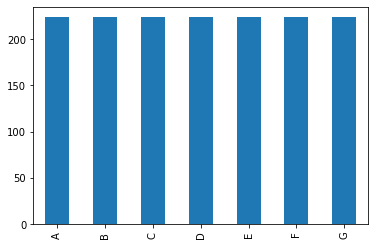

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
y_resampled_SMOTE.value_counts().sort_index().plot.bar()

### Create test set

In [24]:
from sklearn.model_selection import train_test_split, cross_val_predict
X_train, X_test, y_train_b, y_test_b = train_test_split(X_resampled_SMOTE, y_resampled_SMOTE, 
                                             test_size=0.20, random_state=42)

### Random forest algorithm
On garde la 3ème technique qui est la meilleure

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(max_depth=None, oob_score=True, max_features='sqrt', n_jobs=-1)
clf_3_ADASYN = GridSearchCV(estimator=random_forest, 
                     param_grid={'criterion': ('gini', 'entropy'),
                               'class_weight': ('balanced', 'balanced_subsample'),
                               'ccp_alpha': np.linspace(start=0, stop=0.02, num=50)})

clf_3_ADASYN.fit(X_train, y_train_b)

GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt', n_jobs=-1,
                                              oob_score=True),
             param_grid={'ccp_alpha': array([0.        , 0.00040816, 0.00081633, 0.00122449, 0.00163265,
       0.00204082, 0.00244898, 0.00285714, 0.00326531, 0.00367347,
       0.00408163, 0.0044898 , 0.00489796, 0.00530612, 0.00571429,
       0.00612245, 0.00653061, 0.00693878, 0.00734694, 0.0077551 ,
       0.00816327, 0.0085...
       0.01020408, 0.01061224, 0.01102041, 0.01142857, 0.01183673,
       0.0122449 , 0.01265306, 0.01306122, 0.01346939, 0.01387755,
       0.01428571, 0.01469388, 0.01510204, 0.0155102 , 0.01591837,
       0.01632653, 0.01673469, 0.01714286, 0.01755102, 0.01795918,
       0.01836735, 0.01877551, 0.01918367, 0.01959184, 0.02      ]),
                         'class_weight': ('balanced', 'balanced_subsample'),
                         'criterion': ('gini', 'entropy')})

In [28]:
clf_3_ADASYN.best_params_

{'ccp_alpha': 0.00040816326530612246,
 'class_weight': 'balanced',
 'criterion': 'gini'}

In [29]:
clf_3_ADASYN.best_estimator_.oob_score_

0.960127591706539

In [30]:
clf_3_ADASYN.score(X=X_test, y=y_test_b)



0.9426751592356688

A travers cette expérience, on se rend compte qu'il vaut mieux dupliquer les échantillons pour avoir un jeu de données 
équilibré plutot que de créer de nouveaux échantillons.

